# Table of Contents
 <p><div class="lev1 toc-item"><a href="#Masking" data-toc-modified-id="Masking-1"><span class="toc-item-num">1&nbsp;&nbsp;</span>Masking</a></div><div class="lev2 toc-item"><a href="#Masking-with-where:" data-toc-modified-id="Masking-with-where:-11"><span class="toc-item-num">1.1&nbsp;&nbsp;</span>Masking with where:</a></div>

# Masking

In [1]:
import warnings
warnings.filterwarnings('ignore')
%matplotlib inline
import matplotlib.pyplot as plt
import matplotlib
matplotlib.style.use('seaborn')
matplotlib.rcParams['figure.figsize'] = (12, 15)
import numpy as np
import pandas as pd
import seaborn as sns
import holoviews as hv
import geoviews as gv
import geoviews.feature as gf
import xarray as xr
from cartopy import crs

hv.notebook_extension()

## Masking with where:
So far we have used indexing to return subsets of the original. The subset array shape will be different from the original. However, we often want to retain the array shape and mask out some observations. There are applications here in remote sensing, land cover modeling, etc.

Suppose we need to determine which grid cells had temperatures > 20 deg C on June 15, 2008? We will use where() for this selection:

In [2]:
ds = xr.open_dataset('/home/abanihi/Documents/climate-data/CMIP/CMIP5/NCAR/CCSM4/historical/mon/atmos/Amon/r6i1p1/v20160829/ta_Amon_CCSM4_historical_r6i1p1_195001-200512.nc', chunks={'lat':10, 'lon':10})

In [3]:
ds.chunks

Frozen(SortedKeysDict({'time': (672,), 'bnds': (2,), 'lat': (10, 10, 10, 10, 10, 10, 10, 10, 10, 10, 10, 10, 10, 10, 10, 10, 10, 10, 10, 2), 'lon': (10, 10, 10, 10, 10, 10, 10, 10, 10, 10, 10, 10, 10, 10, 10, 10, 10, 10, 10, 10, 10, 10, 10, 10, 10, 10, 10, 10, 8), 'plev': (17,)}))

In [4]:
ds

<xarray.Dataset>
Dimensions:    (bnds: 2, lat: 192, lon: 288, plev: 17, time: 672)
Coordinates:
  * time       (time) datetime64[ns] 1950-01-16T12:00:00 1950-02-15 ...
  * plev       (plev) float64 1e+05 9.25e+04 8.5e+04 7e+04 6e+04 5e+04 4e+04 ...
  * lat        (lat) float64 -90.0 -89.06 -88.12 -87.17 -86.23 -85.29 -84.35 ...
  * lon        (lon) float64 0.0 1.25 2.5 3.75 5.0 6.25 7.5 8.75 10.0 11.25 ...
Dimensions without coordinates: bnds
Data variables:
    time_bnds  (time, bnds) float64 3.65e+04 3.653e+04 3.653e+04 3.656e+04 ...
    lat_bnds   (lat, bnds) float64 -90.0 -89.53 -89.53 -88.59 -88.59 -87.64 ...
    lon_bnds   (lon, bnds) float64 -0.625 0.625 0.625 1.875 1.875 3.125 ...
    ta         (time, plev, lat, lon) float64 nan nan nan nan nan nan nan ...
Attributes:
    institution:                  NCAR (National Center for Atmospheric Resea...
    institute_id:                 NCAR
    experiment_id:                historical
    source:                       CCSM4
    mod

[########################################] | 100% Completed | 58.9s
CPU times: user 39.5 s, sys: 32.3 s, total: 1min 11s
Wall time: 2min 31s


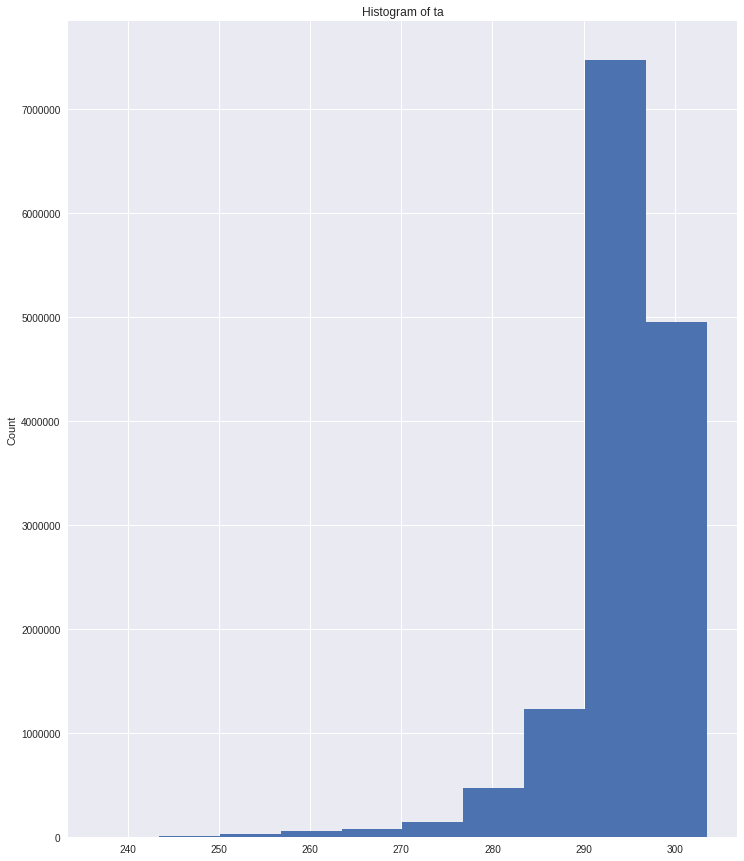

In [5]:
from dask.diagnostics import ProgressBar
with ProgressBar():
    
    %time ds.sel(time="2000-01-16T12:00:00")['ta'].where(ds.ta > 293.15).plot()

In [ ]:
a

In [ ]:
a.chunk

In [ ]:
a.nbytes *(2**-30)

In [ ]:
a.chunks